In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [2]:
print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 2.2.0


In [3]:
train_image_path=glob.glob('./data/dc/training_set/*/*.jpg')
test_image_path=glob.glob('./data/dc/test_set/*/*.jpg')
print(len(train_image_path))
print(len(test_image_path))

8005
2023


In [4]:
train_image_label=[int(os.path.basename(p).split('.')[0]=='cat') for p in train_image_path]
test_image_label=[int(os.path.basename(p).split('.')[0]=='cat') for p in test_image_path]


In [5]:
test_image_label[-5:]

[0, 0, 0, 0, 0]

In [6]:
def load_preprocess_image(path,label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[320,320])
    image = tf.image.random_crop(image,[256,256,3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
#     image = tf.image.random_brightness(image,0.5)
#     image = tf.image.random_contrast(image,0,1)
    image = tf.cast(image, tf.float32)
    image = image/255
    label = tf.reshape(label,[1])
    return image,label

In [7]:
def load_preprocess_image_test(path,label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[256,256])
    image = tf.cast(image, tf.float32)
    image = image/255
    label = tf.reshape(label,[1])
    return image,label

In [8]:
train_image_ds=tf.data.Dataset.from_tensor_slices((train_image_path, train_image_label))
test_image_ds=tf.data.Dataset.from_tensor_slices((test_image_path, test_image_label))

In [9]:
AUTOTUNE=tf.data.experimental.AUTOTUNE
train_image_ds=train_image_ds.map(load_preprocess_image,num_parallel_calls=AUTOTUNE)
test_image_ds=test_image_ds.map(load_preprocess_image_test,num_parallel_calls=AUTOTUNE)

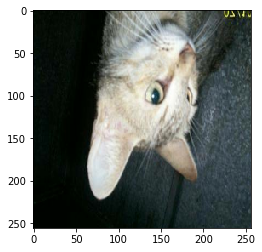

In [10]:
for img, label in train_image_ds.take(1):
    plt.imshow(img)

In [11]:
BATCH_SIZE=128
train_count = len(train_image_path)
train_image_ds=train_image_ds.shuffle(train_count).batch(BATCH_SIZE)
train_image_ds=train_image_ds.prefetch(AUTOTUNE)

test_image_ds=test_image_ds.batch(BATCH_SIZE)
test_image_ds=test_image_ds.prefetch(AUTOTUNE)

In [12]:
# imgs, lables = next(iter(train_image_ds))
# imgs.shape

In [13]:
# plt.imshow(imgs[0])



In [14]:
# lables[0]

In [15]:
model = keras.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),input_shape=(256,256,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(1024,(3,3),activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 127, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 256)       2

In [16]:
# pred = model(imgs)
# pred.shape

#
# np.array([p[0].numpy() for p in tf.cast(pred>0, tf.int32)])
#
#
#
# np.array([l[0].numpy() for l in lables])
#
#
# ls = tf.keras.losses.BinaryCrossentropy()
# ls([[0.],[0.],[1.],[1.]],[[1.],[1.],[1.],[1.]])
#
#
#
# tf.keras.losses.binary_crossentropy([0.,0.,1.,1.],[1.,1.,1.,1.])

In [17]:
optimizer=tf.keras.optimizers.Adam()

In [18]:
epoch_loss_avg=tf.keras.metrics.Mean('train_loss')
train_accuracy=tf.keras.metrics.Accuracy()

test_loss_avg=tf.keras.metrics.Mean('test_loss')
test_accuracy=tf.keras.metrics.Accuracy()

In [19]:
def train_step(model,images,labels):
    with tf.GradientTape() as t:
        pred = model(images)
        loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels,pred)
    grads = t.gradient(loss_step,model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))
    epoch_loss_avg(loss_step)
    train_accuracy(labels,tf.cast(pred>0,tf.int32))

In [20]:
def test_step(model,images,labels):
    pred_test = model.predict(images)
    loss_step_test = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels,pred_test)
    test_loss_avg(loss_step_test)
    test_accuracy(labels,tf.cast(pred_test>0,tf.int32))

In [21]:

num_epoch=30

import datetime
current_time=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir='logs/dog_cat'+current_time+'/train'
test_log_dir='logs/dog_cat'+current_time+'/test'

train_writer=tf.summary.create_file_writer(train_log_dir)
test_writer=tf.summary.create_file_writer(test_log_dir)

In [ ]:
for epoch in range(num_epoch):
    for imgs_,lables_ in train_image_ds:
        train_step(model,imgs_,lables_)
        print('.',end='')
    print()
    with train_writer.as_default():
        tf.summary.scalar('train_loss',epoch_loss_avg.result(),step=epoch)
        tf.summary.scalar('train_acc',train_accuracy.result(),step=epoch)


    for imgs_,lables_ in test_image_ds:
        test_step(model,imgs_,lables_)
        print('.',end='')
    print()
    with test_writer.as_default():
        tf.summary.scalar('test_loss',test_loss_avg.result(),step=epoch)
        tf.summary.scalar('test_acc',test_accuracy.result(),step=epoch)

    print("Epoch:{}; loss:{:.3f}; accuracy:{:.3f}; test_loss{:.3f},accuracy_test:{:.3f}".format(
        epoch+1,
        epoch_loss_avg.result(),
        train_accuracy.result(),
        test_loss_avg.result(),
        test_accuracy.result()
    ))
    epoch_loss_avg.reset_states()
    train_accuracy.reset_states()
    test_loss_avg.reset_states()
    test_accuracy.reset_states()


...............................................................
................
Epoch:1; loss:0.695; accuracy:0.498; test_loss0.691,accuracy_test:0.500
...............................................................
................
Epoch:2; loss:0.693; accuracy:0.517; test_loss0.693,accuracy_test:0.500
...............................................................
................
Epoch:3; loss:0.693; accuracy:0.516; test_loss0.692,accuracy_test:0.504
...............................................................
................
Epoch:4; loss:0.690; accuracy:0.527; test_loss0.683,accuracy_test:0.588
...............................................................
................
Epoch:5; loss:0.675; accuracy:0.576; test_loss0.714,accuracy_test:0.521
...............................................................
................
Epoch:6; loss:0.655; accuracy:0.612; test_loss0.644,accuracy_test:0.635
...............................................................
................
E